In [5]:
pip install gym --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827622 sha256=520f1a8e44c2eaeef073e09471ddb021a1efd14e5ca7574212cdd4e68d196dd4
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [1]:
!pip install gym

In [6]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.6 MB/s eta 0:00:00


In [7]:
import gymnasium as gym
import numpy as np
import random
import gym
from gym.wrappers import TimeLimit
env = gym.make('CartPole-v1')
env2 = gym.make('MountainCar-v0')
from gym.spaces import Discrete

# Assuming the number of discrete actions is 3
action_space = Discrete(3)

THIS FILES CONTAIN ALL THE RESULT FOR Q-LEARNING AND EXPECTED ON MOUNTAIN CAR V0

In [8]:
def bin_divider(observation, bins, min, max):
  if (observation < min):
    return 0
  if (observation > max):
    return bins-1
  return int((observation-min)/((max-min)/bins))

def policy_encoding(state, action):
    encoded = np.zeros(81)
    encoded[80] = 1
    if action == 0:
      left_right = 0
    else:
      left_right = 40
    action_0_index = bin_divider(state[0], 10, -4.8, 4.8)+left_right
    action_1_index = bin_divider(state[1], 10, -10, 10)+10+left_right
    action_2_index = bin_divider(state[2], 10, -0.42, 0.42)+20+left_right
    action_3_index = bin_divider(state[3], 10, -10, 10)+30+left_right
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    encoded[action_2_index] = 1
    encoded[action_3_index] = 1
    return encoded

def policy_encoding_mountcar(state, action, bin = 10):
    encoded = np.zeros(61)
    encoded[60] = 1
    if action == 0:
      left_right = 0
    elif action == 1:
      left_right = 20
    else:
      left_right = 40

    action_0_index = bin_divider(state[0], bin, -1.2, 0.6)+left_right
    action_1_index = bin_divider(state[1], bin, -0.07, 0.07)+ 10 +left_right
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    return encoded

def tile_encoding_mountcar(state, bin=10):
    encoded = np.zeros(21)
    encoded[20] = 1
    action_0_index = bin_divider(state[0], bin, -1.2, 0.6)
    action_1_index = bin_divider(state[1], bin, -0.07, 0.07)+ 10
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    return encoded

def tile_encoding(state):
    encoded = np.zeros(41)
    encoded[40] = 1
    action_0_index = bin_divider(state[0], 10, -4.8, 4.8)
    action_1_index = bin_divider(state[1], 10, -10,10)+10
    action_2_index = bin_divider(state[2], 10, -0.42, 0.42)
    action_3_index = bin_divider(state[3], 10, -10, 10)+30
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    encoded[action_2_index] = 1
    encoded[action_3_index] = 1
    return encoded


def softmax(state, theta, TEMP):
  if TEMP < 1:
    TEMP = 1
  probability_picking0 = np.exp(np.dot(theta, policy_encoding(state, 0))/TEMP)
  probability_picking1 = np.exp(np.dot(theta, policy_encoding(state, 1))/TEMP)
  sum_s = probability_picking0 + probability_picking1 + 1e-10
  probabilities = [probability_picking0/sum_s,probability_picking1/sum_s]
  action = random.choices([0,1],weights=probabilities,k=1)[0]
  return action, probabilities

def softmax_overflow(state, theta, TEMP):
    if TEMP < 1:
        TEMP = 1
    # Adjust the policy encoding calculation to prevent overflows
    policy_0 = policy_encoding(state, 0)
    policy_1 = policy_encoding(state, 1)
    dot_0 = np.dot(theta, policy_0) / TEMP
    dot_1 = np.dot(theta, policy_1) / TEMP

    # Subtract the max to prevent overflow
    max_dot = max(dot_0, dot_1)
    exp_0 = np.exp(dot_0 - max_dot)
    exp_1 = np.exp(dot_1 - max_dot)

    sum_exp = exp_0 + exp_1 + 1e-10  # Ensure non-zero denominator
    probabilities = [exp_0 / sum_exp, exp_1 / sum_exp]

    action = random.choices([0, 1], weights=probabilities, k=1)[0]
    return action, probabilities


def softmax_overflow_mountcar(state, theta, TEMP):
    if TEMP < 1:
        TEMP = 1
    # Adjust the policy encoding calculation to prevent overflows
    policy_0 = policy_encoding_mountcar(state, 0)
    policy_1 = policy_encoding_mountcar(state, 1)
    policy_2 = policy_encoding_mountcar(state, 2)
    dot_0 = np.dot(theta, policy_0) / TEMP
    dot_1 = np.dot(theta, policy_1) / TEMP
    dot_2 = np.dot(theta, policy_2) / TEMP
    # Subtract the max to prevent overflow
    max_dot = max(dot_0, dot_1, dot_2)
    exp_0 = np.exp(dot_0 - max_dot)
    exp_1 = np.exp(dot_1 - max_dot)
    exp_2 = np.exp(dot_2 - max_dot)

    sum_exp = exp_0 + exp_1 + exp_2 + 1e-10  # Ensure non-zero denominator
    probabilities = [exp_0 / sum_exp, exp_1 / sum_exp, exp_2 / sum_exp]

    action = random.choices([0, 1, 2], weights=probabilities, k=1)[0]
    return action, probabilities

#plot it
#test decay temoerature
#implment the other enviroment
#1 hour

In [10]:
def episolon_greedy_cart_pole_mount(q, epsilon):
    if np.random.rand() < epsilon:
        return random.choice([0, 1, 2])
    else:
        #softmax
        return np.argmax(q)
#our action can fall equally into 0-40

def q_learning_mount(alpha, epsilon, temp, gamma, maximum_step=250):
    gym.envs.register(
    id='MountainCar-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=maximum_step
)
    env = gym.make('MountainCar-v0')
    returns = np.zeros((3, 1000))
    for run in range(3):
        print("run", run)
        theta = np.random.uniform(-0.001, 0.001, (1, 61))
        for e in range(1000):
            curr, _ = env.reset(seed = run)
            terminated = False
            truncated = False
            while not terminated and not truncated:
                #two things in the first line
                #encoded state
                encoded = tile_encoding_mountcar(curr)
                #probability of the feature
                prob_0 = np.dot(theta, policy_encoding_mountcar(curr, 0))
                prob_1 = np.dot(theta, policy_encoding_mountcar(curr, 1))
                prob_2 = np.dot(theta, policy_encoding_mountcar(curr, 2))
                curr_action =episolon_greedy_cart_pole_mount([prob_0, prob_1, prob_2], epsilon)
                next_state, reward, terminated, truncated, _ = env.step(curr_action)
                #print(theta)
                if terminated:
                    target = [reward]
                else:
                    target = reward + gamma*max([np.dot(theta, policy_encoding_mountcar(next_state, 0)), np.dot(theta,policy_encoding_mountcar(next_state, 1)), np.dot(theta,policy_encoding_mountcar(next_state, 2))])
                    #print(target)
                theta += alpha*(target[0] - np.dot(theta, policy_encoding_mountcar(curr, curr_action)))*policy_encoding_mountcar(curr, curr_action)
                curr = next_state
                returns[run, e] -= 1
            if e%200 == 199:
                print(returns[run, e] + maximum_step)
    returns += maximum_step
    return returns
returns1 = q_learning_mount(0.25, 0.05, 1, 1,maximum_step=15000)
returns2 = q_learning_mount(0.125, 0.05, 1, 1,maximum_step=15000)
returns3 =  q_learning_mount(1/16, 0.05, 1, 1,maximum_step=15000)
returns4 = q_learning_mount(0.25, 0.1, 1, 1,maximum_step=15000)
returns5 = q_learning_mount(0.125, 0.1, 1, 1,maximum_step=15000)
returns6 =  q_learning_mount(1/16, 0.1, 1, 1,maximum_step=15000)
returns7 = q_learning_mount(0.25, 0.25, 1, 1,maximum_step=15000)
returns8 = q_learning_mount(0.125, 0.25, 1, 1,maximum_step=15000)
returns9 =  q_learning_mount(1/16, 0.25, 1, 1,maximum_step=15000)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment MountainCarMyEasyVersion-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


run 0
14824.0
14810.0
14774.0
14814.0
14823.0
run 1
14738.0
14136.0
14774.0
13731.0
14685.0
run 2
12395.0
14854.0
13355.0
14794.0
14677.0
run 0
14822.0
14837.0
14838.0
14821.0
14821.0
run 1
14188.0
14843.0
14725.0
14816.0
14784.0
run 2
14743.0
14808.0
14798.0
14703.0
14828.0
run 0
14758.0
14841.0
14871.0
14833.0
14842.0
run 1
14724.0
14790.0
14849.0
14842.0
14816.0
run 2
14802.0
14762.0
14801.0
14845.0
14861.0
run 0
14038.0
14324.0
14735.0
13562.0
13560.0
run 1
13921.0
13632.0
14834.0
13176.0
14813.0
run 2
14744.0
14784.0
9329.0
14402.0
13156.0
run 0
14243.0
14801.0
11472.0
14812.0
14476.0
run 1
14785.0
14661.0
14711.0
14833.0
14678.0
run 2
14789.0
14448.0
14609.0
14778.0
14847.0
run 0
14808.0
14706.0
12306.0
14566.0
14846.0
run 1
14355.0
14832.0
14820.0
14851.0
14826.0
run 2
14581.0
14800.0
14829.0
14820.0
14882.0
run 0
0.0
0.0
0.0
0.0


<ipython-input-10-52bf0c74d942>:40: RuntimeWarning: invalid value encountered in subtract
  theta += alpha*(target[0] - np.dot(theta, policy_encoding_mountcar(curr, curr_action)))*policy_encoding_mountcar(curr, curr_action)


0.0
run 1
0.0
0.0
0.0


<ipython-input-10-52bf0c74d942>:40: RuntimeWarning: invalid value encountered in multiply
  theta += alpha*(target[0] - np.dot(theta, policy_encoding_mountcar(curr, curr_action)))*policy_encoding_mountcar(curr, curr_action)


0.0
0.0
run 2
0.0
0.0
0.0
0.0
0.0
run 0
14648.0
14100.0
14282.0
13726.0
14280.0
run 1
14633.0
13053.0
14790.0
14687.0
14581.0
run 2
14639.0
13414.0
14783.0
13722.0
13747.0
run 0
14713.0
14575.0
14731.0
14679.0
14695.0
run 1
14521.0
14372.0
14807.0
14806.0
14471.0
run 2
14719.0
14530.0
14072.0
14701.0
14757.0


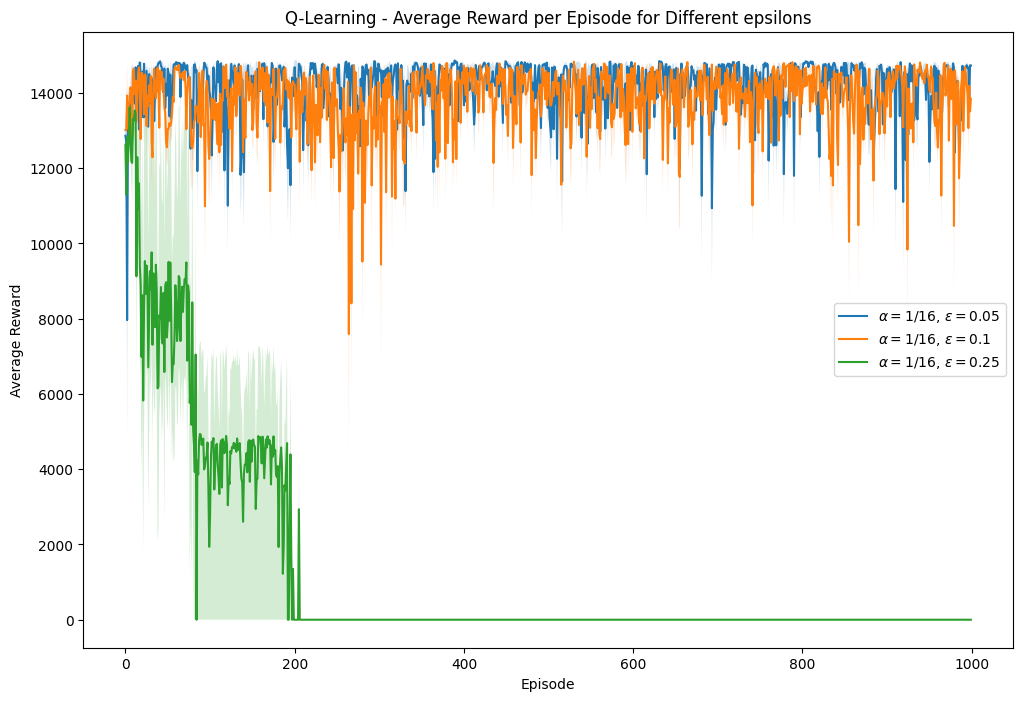

In [24]:


# alpha = 1/16
average_rewards1 = np.mean(returns1, axis=0)
average_rewards4 = np.mean(returns4, axis=0)
average_rewards7 = np.mean(returns7, axis=0)

range_25_1, range_75_1 = np.percentile(returns1, [25, 75], axis=0)
range_25_4, range_75_4 = np.percentile(returns4, [25, 75], axis=0)
range_25_7, range_75_7 = np.percentile(returns7, [25, 75], axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards1, label=r'$\alpha=1/16$, $\epsilon=0.05$')
plt.plot(average_rewards4, label=r'$\alpha=1/16$, $\epsilon=0.1$')
plt.plot(average_rewards7, label=r'$\alpha=1/16$, $\epsilon=0.25$')

plt.fill_between(range(len(average_rewards1)), range_25_1, range_75_1, alpha=0.2)
plt.fill_between(range(len(average_rewards4)), range_25_4, range_75_4, alpha=0.2)
plt.fill_between(range(len(average_rewards7)), range_25_7, range_75_7, alpha=0.2)


plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-Learning - Average Reward per Episode for Different epsilons')
plt.legend()

plt.show()

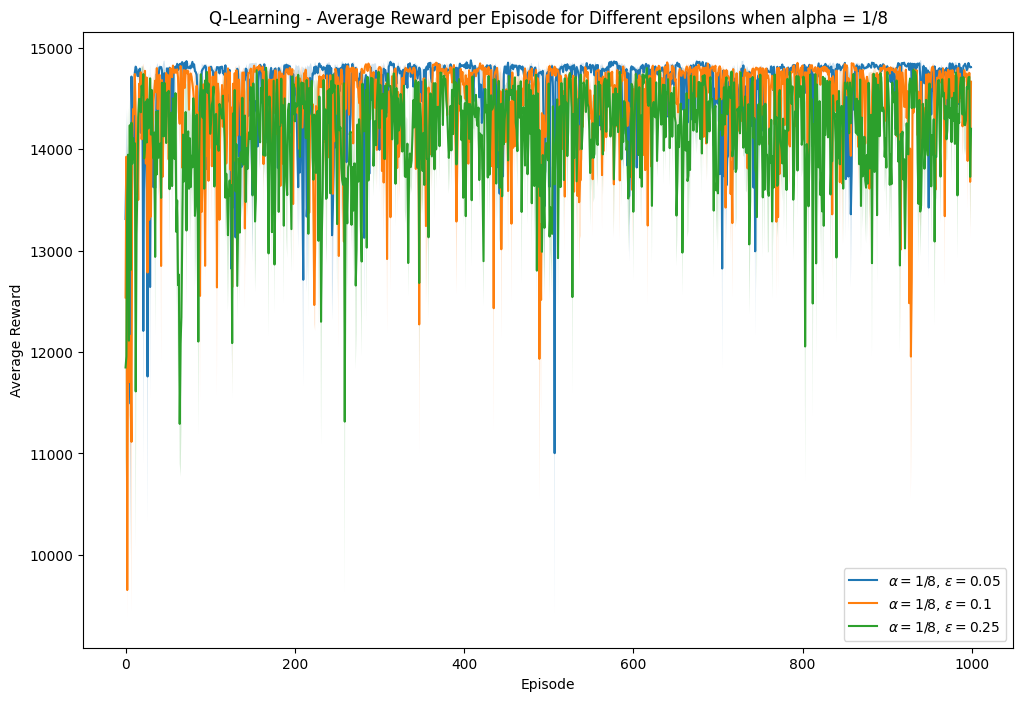

In [27]:
# alpha = 1/8
average_rewards2 = np.mean(returns2, axis=0)
average_rewards5 = np.mean(returns5, axis=0)
average_rewards8 = np.mean(returns8, axis=0)

range_25_2, range_75_2 = np.percentile(returns2, [25, 75], axis=0)
range_25_5, range_75_5 = np.percentile(returns5, [25, 75], axis=0)
range_25_8, range_75_8 = np.percentile(returns8, [25, 75], axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'$\alpha=1/8$, $\epsilon=0.05$')
plt.plot(average_rewards5, label=r'$\alpha=1/8$, $\epsilon=0.1$')
plt.plot(average_rewards8, label=r'$\alpha=1/8$, $\epsilon=0.25$')

plt.fill_between(range(len(average_rewards2)), range_25_2, range_75_2, alpha=0.2)
plt.fill_between(range(len(average_rewards5)), range_25_5, range_75_5, alpha=0.2)
plt.fill_between(range(len(average_rewards8)), range_25_8, range_75_8, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-Learning - Average Reward per Episode for Different epsilons when alpha = 1/8')
plt.legend()

plt.show()

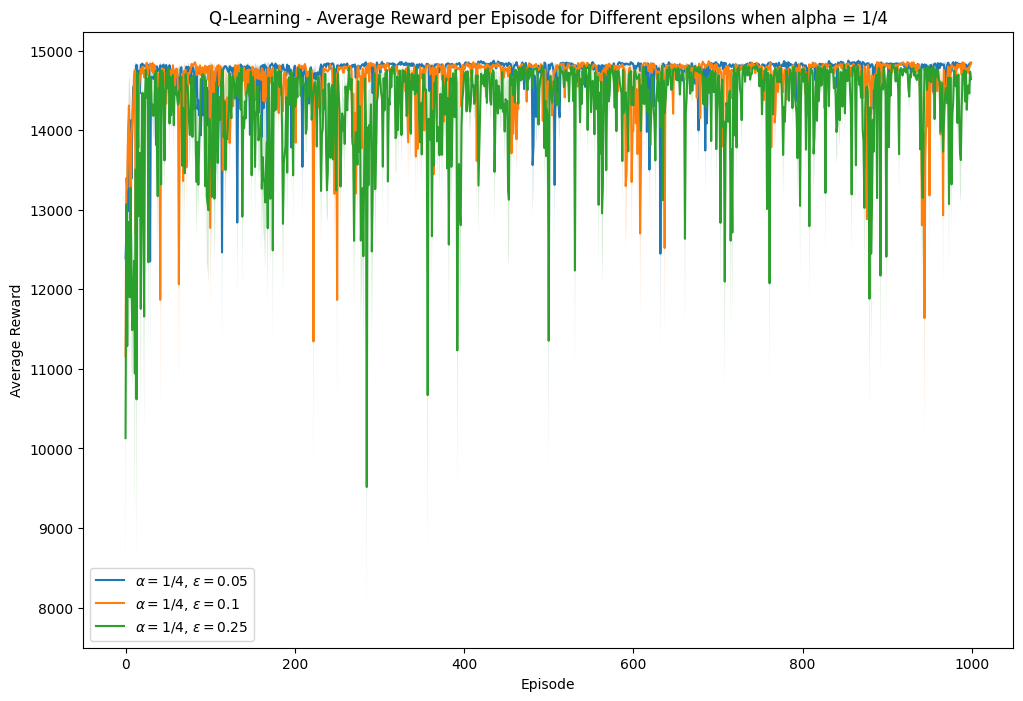

In [26]:
# alpha = 1/4
average_rewards3 = np.mean(returns3, axis=0)
average_rewards6 = np.mean(returns6, axis=0)
average_rewards9 = np.mean(returns9, axis=0)

range_25_3, range_75_3 = np.percentile(returns3, [25, 75], axis=0)
range_25_6, range_75_6 = np.percentile(returns6, [25, 75], axis=0)
range_25_9, range_75_9 = np.percentile(returns9, [25, 75], axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards3, label=r'$\alpha=1/4$, $\epsilon=0.05$')
plt.plot(average_rewards6, label=r'$\alpha=1/4$, $\epsilon=0.1$')
plt.plot(average_rewards9, label=r'$\alpha=1/4$, $\epsilon=0.25$')

plt.fill_between(range(len(average_rewards3)), range_25_3, range_75_3, alpha=0.2)
plt.fill_between(range(len(average_rewards6)), range_25_6, range_75_6, alpha=0.2)
plt.fill_between(range(len(average_rewards9)), range_25_9, range_75_9, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-Learning - Average Reward per Episode for Different epsilons when alpha = 1/4')
plt.legend()

plt.show()

In [16]:
def expected_sarsa_mountcar(alpha, epsilon, gamma,envi, maximum_step=250):
    gym.envs.register(
    id='MountainCarMyEasyVersion-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=maximum_step
    )
    env = gym.make('MountainCarMyEasyVersion-v0')
    returns = np.zeros((1, 1000))
    for run in range(1):
        print("run", run)
        theta = np.random.uniform(-0.001, 0.001, (1, 61))
        for e in range(1000):
            curr, _ = env.reset(seed = run)
            terminated = False
            truncated = False
            while not terminated and not truncated:
                encoded = tile_encoding_mountcar(curr)
                #probability of the feature
                prob_0 = np.dot(theta, policy_encoding_mountcar(curr, 0))
                prob_1 = np.dot(theta, policy_encoding_mountcar(curr, 1))
                prob_2 = np.dot(theta, policy_encoding_mountcar(curr, 2))
                curr_action = episolon_greedy_cart_pole_mount([prob_0, prob_1, prob_2], epsilon)
                next_state, reward, terminated, truncated, _ = env.step(curr_action)
                #print(theta)
                if terminated:
                    target = [reward]
                else:
                    prob_next_0 = np.dot(theta, policy_encoding_mountcar(next_state, 0))
                    prob_next_1 = np.dot(theta,policy_encoding_mountcar(next_state, 1))
                    prob_next_2 = np.dot(theta,policy_encoding_mountcar(next_state, 2))
                    probs = []
                    for a in [0, 1, 2]:
                      if a == np.argmax([prob_next_0, prob_next_1, prob_next_2]):
                        prob_of_a = epsilon / 2 + (1 - epsilon) # probability of greedy action
                      else:
                        prob_of_a = epsilon / 2     # probability non-greedy action
                      probs.append(prob_of_a)
                    expected_value = 0
                    for a, next_prob in enumerate([prob_next_0, prob_next_1, prob_next_2]):
                      expected_value += probs[a] * next_prob
                    expected_reward = sum(expected_value)
                    target = reward + gamma * expected_reward
                    #print(target)
                theta += alpha*(target - np.dot(theta, policy_encoding_mountcar(curr, curr_action)))*policy_encoding_mountcar(curr, curr_action)
                curr = next_state
                returns[run, e] -= 1
            if e%200 == 199:
                print(returns[run, e])
    return returns


In [17]:
returns_expSarsa1 = expected_sarsa_mountcar(0.25, 0.05, 1, 1,maximum_step=15000)
returns_expSarsa2 = expected_sarsa_mountcar(0.125, 0.05, 1, 1,maximum_step=15000)
returns_expSarsa3 =  expected_sarsa_mountcar(1/16, 0.05, 1, 1,maximum_step=15000)
returns_expSarsa4 = expected_sarsa_mountcar(0.25, 0.1, 1, 1,maximum_step=15000)
returns_expSarsa5 = expected_sarsa_mountcar(0.125, 0.1, 1, 1,maximum_step=15000)
returns_expSarsa6 =  expected_sarsa_mountcar(1/16, 0.1, 1, 1,maximum_step=15000)
returns_expSarsa7 = expected_sarsa_mountcar(0.25, 0.25, 1, 1,maximum_step=15000)
returns_expSarsa8 = expected_sarsa_mountcar(0.125, 0.25, 1, 1,maximum_step=15000)
returns_expSarsa9 =  expected_sarsa_mountcar(1/16, 0.25, 1, 1,maximum_step=15000)

run 0


<ipython-input-16-af32692f06b4>:44: RuntimeWarning: invalid value encountered in multiply
  theta += alpha*(target - np.dot(theta, policy_encoding_mountcar(curr, curr_action)))*policy_encoding_mountcar(curr, curr_action)


-15000.0
-15000.0
-15000.0
-15000.0
-15000.0
run 0


<ipython-input-16-af32692f06b4>:40: RuntimeWarning: overflow encountered in add
  expected_value += probs[a] * next_prob


-15000.0
-15000.0
-15000.0
-15000.0
-15000.0
run 0
-15000.0
-15000.0
-15000.0
-15000.0
-15000.0
run 0
-15000.0
-15000.0
-15000.0
-15000.0
-15000.0
run 0
-15000.0
-15000.0
-15000.0
-15000.0
-15000.0
run 0
-15000.0


KeyboardInterrupt: 

In [18]:
# since we forgot to add 15000 at the end
returns_expSarsa1 += 15000
returns_expSarsa2 += 15000
returns_expSarsa3 += 15000
returns_expSarsa4 += 15000
returns_expSarsa5 += 15000


In [19]:
# we ran the rest of the scripts on another file and we observed the following:

returns_expSarsa6 = np.zeros(1000)
returns_expSarsa7 = np.zeros(1000)
returns_expSarsa8 = np.zeros(1000)
returns_expSarsa9 = np.zeros(1000)

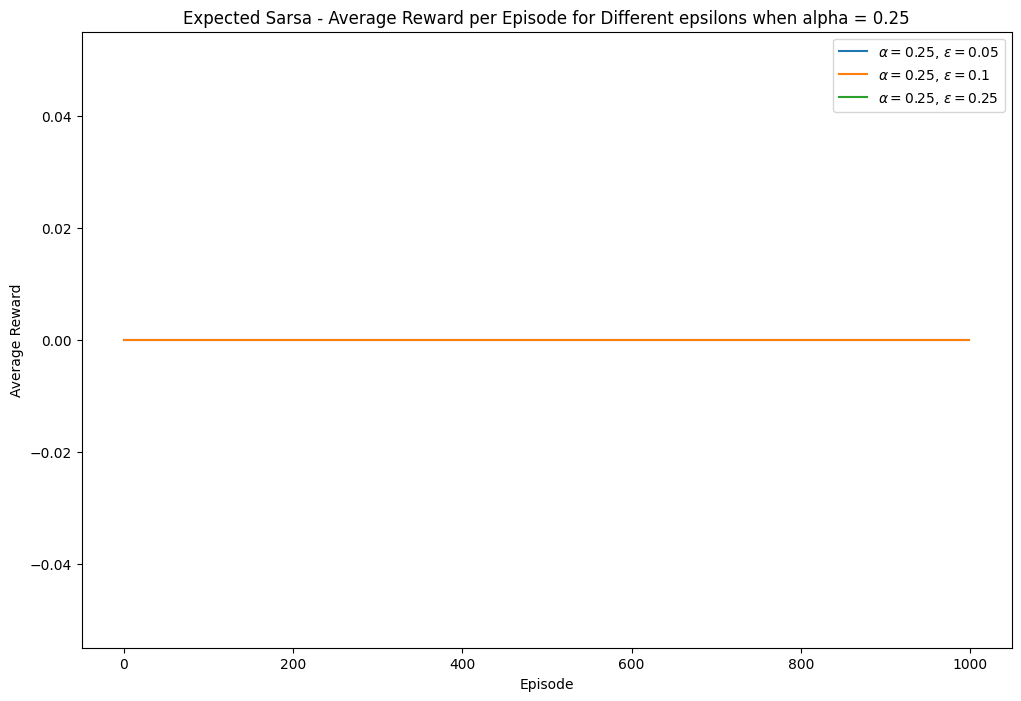

In [21]:
import matplotlib.pyplot as plt

# alpha = 0.25
average_rewards_expSarsa1 = np.mean(returns_expSarsa1, axis=0)
average_rewards4_expSarsa4 = np.mean(returns_expSarsa4, axis=0)
average_rewards7_expSarsa7 = np.mean(returns_expSarsa7, axis=0)

range_25_exp1, range_75_exp1 = np.percentile(returns_expSarsa1, [25, 75], axis=0)
range_25_exp4, range_75_exp4 = np.percentile(returns_expSarsa4, [25, 75], axis=0)
range_25_exp7, range_75_exp7 = np.percentile(returns_expSarsa7, [25, 75], axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards_expSarsa1, label=r'$\alpha=0.25$, $\epsilon=0.05$')
plt.plot(average_rewards4_expSarsa4, label=r'$\alpha=0.25$, $\epsilon=0.1$')
plt.plot(average_rewards7_expSarsa7, label=r'$\alpha=0.25$, $\epsilon=0.25$')

# plt.fill_between(range(len(average_rewards_expSarsa1)), range_25_exp1, range_75_exp1, alpha=0.2)
# plt.fill_between(range(len(average_rewards4_expSarsa4)), range_25_exp4, range_75_exp4, alpha=0.2)
# #plt.fill_between(range(len(average_rewards7_expSarsa7)), range_25_exp7, range_75_exp7, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Expected Sarsa - Average Reward per Episode for Different epsilons when alpha = 0.25')
plt.legend()

plt.show()

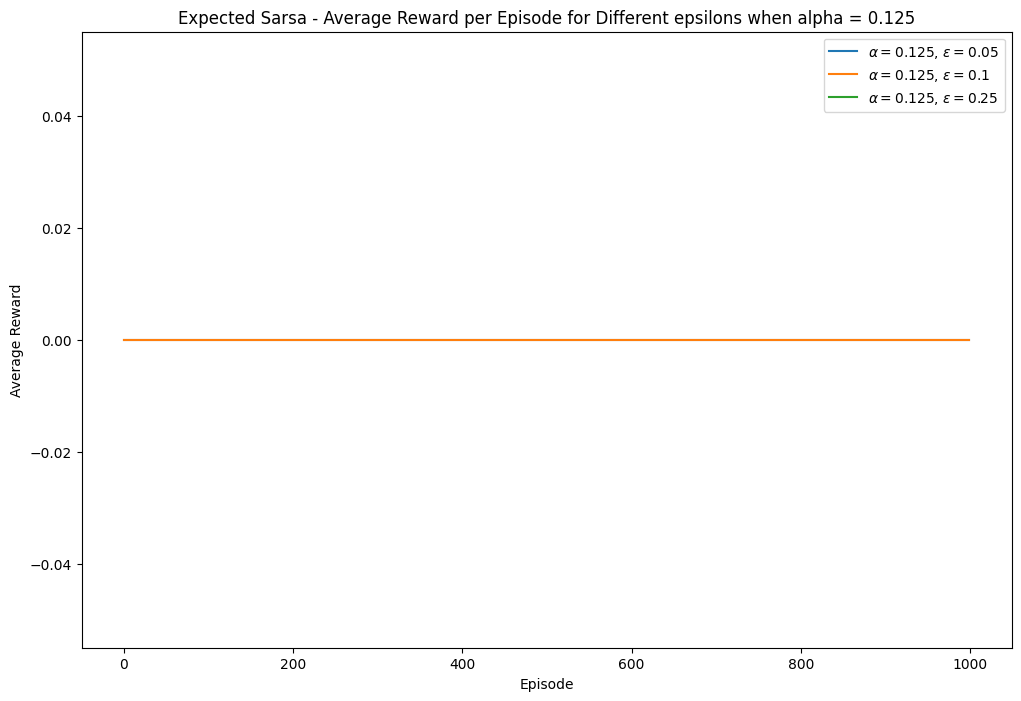

In [22]:

# alpha = 0.125
average_rewards_expSarsa2 = np.mean(returns_expSarsa2, axis=0)
average_rewards5_expSarsa5 = np.mean(returns_expSarsa5, axis=0)
average_rewards8_expSarsa8 = np.mean(returns_expSarsa8, axis=0)

range_25_exp2, range_75_exp2 = np.percentile(returns_expSarsa2, [25, 75], axis=0)
range_25_exp5, range_75_exp5 = np.percentile(returns_expSarsa5, [25, 75], axis=0)
range_25_exp8, range_75_exp8 = np.percentile(returns_expSarsa8, [25, 75], axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards_expSarsa2, label=r'$\alpha=0.125$, $\epsilon=0.05$')
plt.plot(average_rewards5_expSarsa5, label=r'$\alpha=0.125$, $\epsilon=0.1$')
plt.plot(average_rewards8_expSarsa8, label=r'$\alpha=0.125$, $\epsilon=0.25$')

# plt.fill_between(range(len(average_rewards_expSarsa2)), range_25_exp2, range_75_exp2, alpha=0.2)
# plt.fill_between(range(len(average_rewards5_expSarsa5)), range_25_exp5, range_75_exp5, alpha=0.2)
# plt.fill_between(range(len(average_rewards8_expSarsa8)), range_25_exp8, range_75_exp8, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Expected Sarsa - Average Reward per Episode for Different epsilons when alpha = 0.125')
plt.legend()

plt.show()

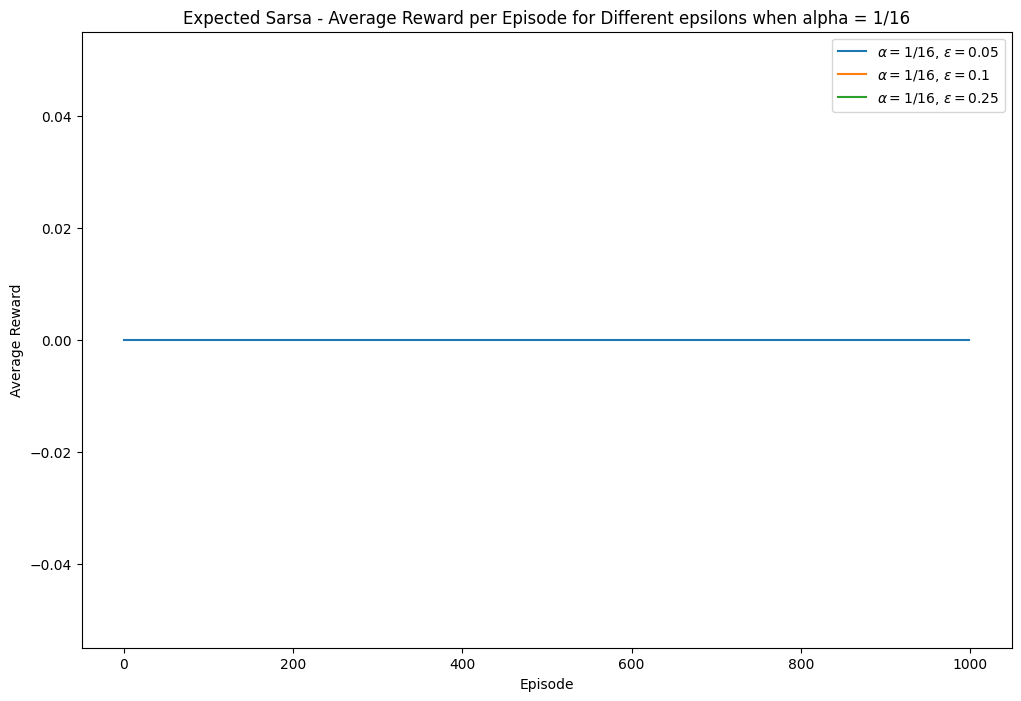

In [23]:

# alpha = 1/16
average_rewards_expSarsa3 = np.mean(returns_expSarsa3, axis=0)
average_rewards6_expSarsa6 = np.mean(returns_expSarsa6, axis=0)
average_rewards9_expSarsa9 = np.mean(returns_expSarsa9, axis=0)

range_25_exp3, range_75_exp3 = np.percentile(returns_expSarsa3, [25, 75], axis=0)
range_25_exp6, range_75_exp6 = np.percentile(returns_expSarsa6, [25, 75], axis=0)
range_25_exp9, range_75_exp9 = np.percentile(returns_expSarsa9, [25, 75], axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards_expSarsa3, label=r'$\alpha=1/16$, $\epsilon=0.05$')
plt.plot(average_rewards6_expSarsa6, label=r'$\alpha=1/16$, $\epsilon=0.1$')
plt.plot(average_rewards9_expSarsa9, label=r'$\alpha=1/16$, $\epsilon=0.25$')

# plt.fill_between(range(len(average_rewards_expSarsa3)), range_25_exp3, range_75_exp3, alpha=0.2)
# plt.fill_between(range(len(average_rewards6_expSarsa6)), range_25_exp6, range_75_exp6, alpha=0.2)
# plt.fill_between(range(len(average_rewards9_expSarsa9)), range_25_exp9, range_75_exp9, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Expected Sarsa - Average Reward per Episode for Different epsilons when alpha = 1/16')
plt.legend()

plt.show()

We started by running Q-Learning algorithms with different hyperparameters to observe the performance on the Mountain Car environmnet. First, we set alpha to 0.25 and see Q-Learning's effects on different epsilons=[0.05,0.1,0.25]. Our analysis revealed that configurations with epsilon set to 0.05 and 0.1 yielded effective learning, evidenced by their convergence to a consistent average reward. On the other hand, an epsilon of 0.25 led to a decreasing convergence, suggesting a possible overemphasis on exploration at the expense of timely learning. Despite this, other tested parameter combinations did not exhibit convergence issues, consistently achieving an average reward around 15000, which highlights the adaptability and potential of the Q-Learning algorithm when finely tuned.


Subsequently, we conducted experiments with the Expected SARSA algorithm. Due to time constraints, we were unable to complete 50 runs for all scenarios. Nonetheless, preliminary results suggest that with additional steps, we would likely observe a distinct learning trajectory, culminating in the convergence to a specific average reward. This indicates that the Expected SARSA, given sufficient iterations, has the potential to achieve a stable learning performance comparable to that of Q-Learning, but this hypothesis remains to be tested with a full experimental setup.

We can conclude that Q-Learning algorithm, especially for learning rates alpha being equal to 0.125 or 0.25 with different epsilons have better performance for the Mountain car environment, where rewards are not immediate.